In [1]:
# -*- coding: utf8

from label_shift.skwrapper import LabelShiftDetectorSKLearn

from statsmodels.distributions.empirical_distribution import ECDF

from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from sklearn import neural_network
from sklearn import linear_model
from sklearn import svm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.ion()

In [2]:
from label_shift.densenet import DenseNet

In [3]:
import warnings
warnings.filterwarnings('ignore')

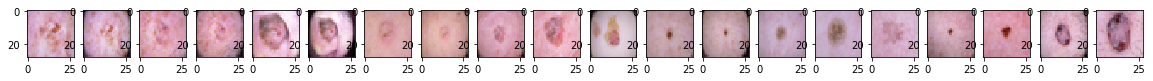

In [4]:
data = pd.read_csv('hmnist_28_28_RGB.csv')
y = data['label'].values
del data['label']
X = data.values / 255

plt.figure(figsize=(20, 4))
for i, xi in enumerate(X[:20]):
    plt.subplot(1, 20, i + 1)
    plt.imshow(xi.reshape((28, 28, 3)))

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                    test_size=0.2)

In [6]:
print(X_train.shape)
print(X_test.shape)

(8012, 2352)
(2003, 2352)


In [7]:
print(len(set(y)))

7


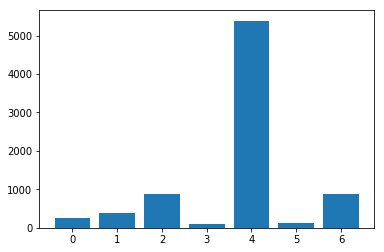

In [8]:
labels, count = np.unique(y_train, return_counts=True)
plt.bar(labels, count);

In [9]:
ko_classes = {4}
ko_prob = 0.9

keep = np.ones(len(y_train), dtype='bool')
for i in range(len(y_train)):
    if y_train[i] in ko_classes and np.random.rand() < ko_prob:
        keep[i] = False

In [10]:
print(keep.sum() / keep.shape[0])

0.3917873190214678


In [11]:
X_train = X_train[keep]
y_train = y_train[keep]

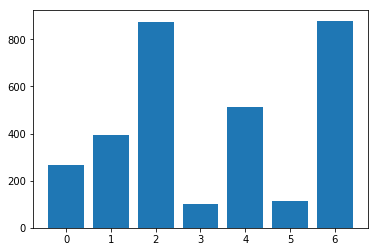

In [12]:
labels, count = np.unique(y_train, return_counts=True)
plt.bar(labels, count);

In [13]:
base = linear_model.LogisticRegressionCV(Cs=5, fit_intercept=False)
classifier = LabelShiftDetectorSKLearn(base)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.00      0.00      0.00       121
           2       0.24      0.63      0.35       224
           3       0.00      0.00      0.00        15
           4       0.90      0.60      0.72      1320
           5       0.36      0.32      0.34        28
           6       0.26      0.57      0.36       234

   micro avg       0.54      0.54      0.54      2003
   macro avg       0.25      0.30      0.25      2003
weighted avg       0.66      0.54      0.56      2003



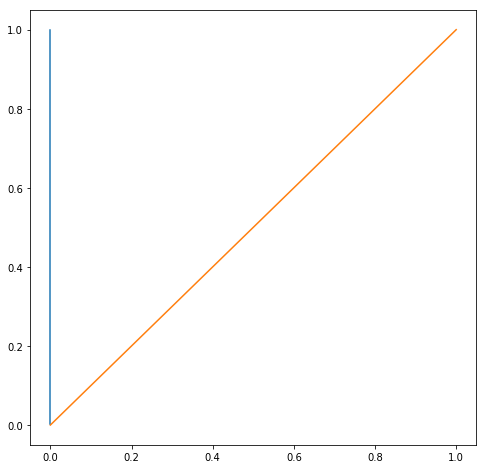

In [14]:
plt.figure(figsize=(8, 8))
p, pvals = classifier.label_shift_detector(X_test, return_bootstrap=True)
ecdf = ECDF(pvals)
plt.plot(ecdf.x, ecdf.y)
plt.plot(ecdf.y, ecdf.y)

In [15]:
p, nrm, kld = classifier.label_shift_detector(X_test, y_test)
print(p, nrm, kld)

4.204765702756897e-31 13.851895410589549 inf


In [16]:
y_pred = classifier.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.00      0.00      0.00       121
           2       0.24      0.63      0.35       224
           3       0.00      0.00      0.00        15
           4       0.90      0.60      0.72      1320
           5       0.36      0.32      0.34        28
           6       0.26      0.57      0.36       234

   micro avg       0.54      0.54      0.54      2003
   macro avg       0.25      0.30      0.25      2003
weighted avg       0.66      0.54      0.56      2003



In [17]:
weights = classifier.wt_est_[:, 0].copy()
weights = weights / weights.sum()
class_weights = {}
for k in range(len(weights)):
    class_weights[k] = weights[k]

new_classifier = linear_model.LogisticRegressionCV(Cs=5, class_weight=class_weights, fit_intercept=False)
new_classifier.fit(X_train, y_train)
y_pred = new_classifier.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.00      0.00      0.00       121
           2       0.18      0.82      0.30       224
           3       0.00      0.00      0.00        15
           4       0.99      0.42      0.59      1320
           5       0.41      0.50      0.45        28
           6       0.25      0.42      0.31       234

   micro avg       0.42      0.42      0.42      2003
   macro avg       0.26      0.31      0.24      2003
weighted avg       0.70      0.42      0.46      2003

